### HW 4 - F3CV

### Name: Amir Hosein haji Mohammad Rezaie

In [4]:
# Preparations
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Fundamental matrix estimation.

a)
Implement the eight-point algorithm. Note the skeleton function and follow the input output structure

b)
Implement the normalized eight-point algorithm.

The epipolar lines obtained with both F-matrix estimates should be close to those visualized
by the example script.

In [9]:
def estimateF(x1,x2):
    
    u1 = x1[:, 0]
    v1 = x1[:, 1]
    u2 = x2[:, 0]
    v2 = x2[:, 1]
    one = np.ones_like(u1)
    
    
    A = np.c_[u1 * u2, v1 * u2, u2, u1 * v2, v1 * v2, v2, u1, v1, one]
    
    U, S, V = np.linalg.svd(A, full_matrices=True)
    f = V[-1, :]
    F = f.reshape(3, 3)
    
    
    U, S, V = np.linalg.svd(F, full_matrices=True)
    S[-1] = 0
    F = U @ np.diag(S) @ V
    return F
        

def estimateFnorm(x1,x2):
    
    c1 = np.mean(x1, axis=0)
    c2 = np.mean(x2, axis=0)
    
    
    s1 = np.sqrt(2 / np.mean(np.sum((x1 - c1) ** 2, axis=1)))
    s2 = np.sqrt(2 / np.mean(np.sum((x2 - c2) ** 2, axis=1)))
    
    T1 = np.array([
        [s1, 0, -s1 * c1[0]],
        [0, s1, -s1 * c1[1]],
        [0, 0 ,1]
    ])
    T2 = np.array([
        [s2, 0, -s2 * c2[0]],
        [0, s2, -s2 * c2[1]],
        [0, 0, 1]
    ])
    
    
    x1_n = T1 @ x1.T
    x2_n = T2 @ x2.T
    
    F_n = estimateF(x1_n.T, x2_n.T)
    
    return T2.T @ F_n @ T1
 
def vgg_F_from_P(P1,P2):
    # Return the fundamental matrix F (3 by 3), based on two camera parameter arrays.
    # Input: P1, P2 numpy ndarray (3 by 4) containing intrinsic and extrinsic parameters.
    # Output: F numpy ndarray (3 by 3) containing the fundamental matrix.
    X=[]
    Y=[]
    X.append(P1[[1,2],:])
    X.append(P1[[2,0],:])
    X.append(P1[[0,1],:])
    Y.append(P2[[1,2],:])
    Y.append(P2[[2,0],:])
    Y.append(P2[[0,1],:])
    F=np.zeros([3,3])
    
    for i in range(3):
        for j in range(3):
            M=np.concatenate([X[j],Y[i]])
            F[i,j]=np.linalg.det(M)
    return F

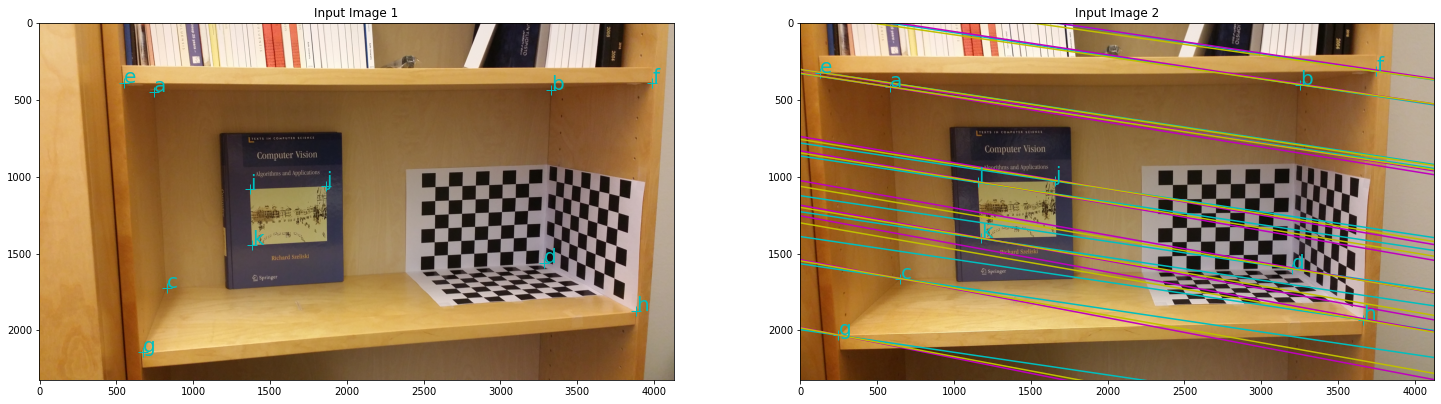

In [10]:
# Point locations
x1 = 1.0e+03*np.array([0.7435,3.3315,0.8275,3.2835,0.5475,3.9875,0.6715,3.8835,1.3715,1.8675,1.3835])
y1 = 1.0e+03*np.array([0.4455,0.4335,1.7215,1.5615,0.3895,0.3895,2.1415,1.8735,1.0775,1.0575,1.4415])
x2 = 1.0e+03*np.array([0.5835,3.2515,0.6515,3.1995,0.1275,3.7475,0.2475,3.6635,1.1555,1.6595,1.1755])
y2 = 1.0e+03*np.array([0.4135,0.4015,1.6655,1.5975,0.3215,0.3135,2.0295,1.9335,1.0335,1.0255,1.3975])

# Camera parameters
P1= np.row_stack([[-0.001162918366053,0.000102986385133,-0.000344703214391,0.995200644722518],\
                 [-0.000019974831639,0.001106889654747,-0.000150591916681,0.097841118173777],\
                 [-0.000000053632777,0.000000044849673,-0.000000270734766,0.000249501614496]])

P2= np.row_stack([[-0.001272880601540, 0.000093061493378,-0.000574486218854, 0.996457618133488],\
                 [-0.000002971652037, 0.001271207503106,-0.000200323351541, 0.084074548573989],\
                 [-0.000000020226464, 0.000000043518811,-0.000000316928290, 0.000265554210072]])

# Make homogenous representations of points
pts1=np.row_stack([x1,y1,np.ones_like(x1)])
pts2=np.row_stack([x2,y2,np.ones_like(x2)])

# Read images
# Read images
im1 = cv2.imread('im1.jpg')
im2 = cv2.imread('im2.jpg')

im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)


# Labels
labels = ['a','b','c','d','e','f','g','h','i','j','k']

# Create figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,25))
ax = axes.ravel()
ax[0].imshow(im1)
ax[0].plot(x1, y1, 'c+', markersize=10)

# Put labels
for i in range(len(x1)):    
    ax[0].annotate(labels[i], (x1[i], y1[i]), color='c', fontsize=20)
ax[0].set_title("Input Image 1")
ax[1].imshow(im2)
ax[1].plot(x2, y2, 'c+', markersize=10)
for i in range(len(x2)):    
    ax[1].annotate(labels[i], (x2[i], y2[i]), color='c', fontsize=20)
ax[1].set_title("Input Image 2")

# Get ground truth fundamental matrix
F=vgg_F_from_P(P1,P2)
#F_org = F.copy()
# Create lines
#eplinesA=F@pts1
#eplinesB=F@pts2
eplinesA=np.dot(F,pts1)
eplinesB=np.dot(F,pts2)

#  Plot lines
px=np.array([0,np.shape(im2)[1]])
for i in range(np.shape(pts1)[1]):
    py=(-eplinesA[0,i]*px-eplinesA[2,i])/eplinesA[1,i]
    ax[1].plot(px,py,'c-');

# Get fundamental matrix and draw epipolar lines
F=estimateF(pts1.T,pts2.T)
#F_1 = F.copy()
#eplinesA=F@pts1
#eplinesB=F@pts2
eplinesA=np.dot(F,pts1)
eplinesB=np.dot(F,pts2)
for i in range(np.shape(pts1)[1]):
    py=(-eplinesA[0,i]*px-eplinesA[2,i])/eplinesA[1,i]
    ax[1].plot(px,py,'m-');

# Get fundamental matrix from normalized algorithm and draw epipolar lines
F=estimateFnorm(pts1.T,pts2.T)
#F_2 = F.copy()
#eplinesA=F@pts1
#eplinesB=F@pts2
eplinesA=np.dot(F,pts1)
eplinesB=np.dot(F,pts2)
for i in range(np.shape(pts1)[1]):
    py=(-eplinesA[0,i]*px-eplinesA[2,i])/eplinesA[1,i]
    ax[1].plot(px,py,'y-');

ax[1].axes.set_xlim([0,np.shape(im2)[1]])
ax[1].axes.set_ylim([np.shape(im2)[0],0])
plt.show()